# Capstone Project - The Battle of Neighborhoods
## Scenario: Brexit Relocation

### Introduction

In June 2016, the United Kingdom voted in a referendum to leave the European Union, which, as the details of the leaving process and future relationship got worked out, became bad news for financial services companies based in the UK as the trade agreement struck between the nation and the trading block has insufficient coverage for such companies to continue trading in the same way as they did before, leading to large shifts in capital and resources from the UK to the EU by companies in a move to ensure that access to the single market is not lost. <br><br>
The client, a financial services company with a substantial portfolio of EU assets under management, currently has its European headquarters in London and due to regulatory and market pressures has already had to follow suit and shift its asset ownership to EU country-registered entities. However, the client does not have an EU-based office – the EU entities it owns are legal/paper entities only - and so we finally arrive at the question we need to answer, which is “where should they move to”? <br><br>
This question, however, is too simple for its own good and as such requires discussion and breakdown. Following conversations with the client, the scope of what is to be delivered is as follows:<br><br>
•	They want to be provided a list (and presentation) of good landing spots as opposed to just one, so that the board can put it to a vote and decide<br>
•	They want as many staff to move with them as possible, and as such, candidate cities must be similar to London in both economic and cultural terms, and their distance to London must be considered as part of the exercise<br>
•	The top 50 EU urban areas by population are to be evaluated, disqualifying any which do not contain an international airport with links to London or a stock exchange<br><br>
As such, the chosen approach is a clustering model that will take in the requisite economic and cultural fit data and split the candidate cities (plus London) into groups, so that we can then extract the cities in the London cluster and present them as our list of viable options.


### Data

As discussed in the Introduction, the base data set to analyse is the top 50 EU urban areas by population, a list of which can be found <a href='https://en.wikipedia.org/wiki/List_of_urban_areas_in_the_European_Union'>here</a>, plus London for comparison purposes. Where an urban area contains multiple cities, it is disambiguated into its component cities, which are only retained if their individual population is higher than the 50th ranked city in our data set.
This means the two composite areas on our list meet different fates - the Ruhr area, originally ranked 2nd, is disqualified (its largest city is Dortmund, which falls 140k short), and the only other composite urban area in the list, Rotterdam/The Hague, is split into two as both urban areas are comfortably in the top 50.<br>

Before assembling any further data, we must evaluate the disqualifying criteria and discard any cities that, per the requirements, do not have either an international airport serving its urban area or house a stock exchange – this leaves us with 28 cities in our preliminary data set.

In [8]:
import pandas as pd
prelim_df = pd.read_csv('cities_data_prelim.csv')
prelim_df.head()

,UrbanArea,Population,Density,IntlAirport,StockExchange
0,Paris,11020000,3800,Y,Y
1,Madrid,6026000,4600,Y,Y
2,Milan,4907000,2800,Y,Y
3,Barcelona,4588000,4300,Y,Y
4,Berlin,3972000,2900,Y,Y


In [10]:
prelim_df.shape

(28, 5)

Once the disqualified cities are removed, we must then locate and fill in the following to satisfy the economic side of our data requirements:
<ul>
    <li>Straight line distance to London</li>
    <li>Percentage of English speakers, according to <a href='https://ec.europa.eu/commfrontoffice/publicopinion/archives/ebs/ebs_386_en.pdf'>an EU Commission report on second languages</a> - assumed 100% in Ireland as English is official language</li>
    <li>Average commercial rental cost, sourced mostly from <a href='https://www.statista.com/statistics/431672/commercial-property-prime-rents-europe/'>this Statista dataset</a> (missing records searched individually)</li>
    <li>Average rental cost and income, sourced mostly from <a href='https://www.kaggle.com/stephenofarrell/cost-of-living'>this Kaggle dataset</a> (missing records searched individually at the source in Numbeo)</li>
    <li><a href='https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index'>HDI of country</a></li>
</ul>

For the cultural fit side, we will be extracting venue data from Foursquare for each city on the list, categorising venue types by popularity and appending the most common venue types to our data set for use by the clustering model. In order to prepare for this, we must also fetch coordinates data for our locations so that this can be fed into the API.<br>

The result will be a data set that looks like this, prior to the venue data imports:        

In [77]:
cities_df = pd.read_csv('cities_data.csv')
cities_df.head()

,UrbanArea,Population,Density,IntlAirport,StockExchange,DistanceToLdn,Lat,Long,HDI,PctFluentEng,CommRent,EmplRent,Income
0,Paris,11020000,3800,Y,Y,343.88,48.856697,2.351462,0.901,0.39,865.0,1177.51,2215.02
1,Madrid,6026000,4600,Y,Y,1264.80,40.416705,-3.703582,0.904,0.22,372.0,933.23,1578.77
2,Milan,4907000,2800,Y,Y,960.25,45.466800,9.190500,0.892,0.34,600.0,1099.67,1601.00
3,Barcelona,4588000,4300,Y,Y,1140.65,41.382894,2.177432,0.904,0.22,336.0,950.28,1444.48
4,Berlin,3972000,2900,Y,Y,931.48,52.517037,13.388860,0.947,0.56,468.0,896.50,2289.46


### Methodology

Before we go any further, a look at the data is required to figure out what data was collected and if we are happy with it. Unfortunately, a few records don't have a commercial rent value because they were absent from the data set we found:

In [19]:
null_data = cities_df[cities_df.isnull().any(axis=1)]
null_data.head()

,UrbanArea,Population,Density,IntlAirport,StockExchange,DistanceToLdn,Lat,Long,HDI,PctFluentEng,CommRent,EmplRent,Income
5,Athens,3325000,5000,Y,Y,2394.28,37.983941,23.728305,0.888,0.51,NaN,377.05,787.01
6,Rotterdam,1160000,3106,Y,Y,319.93,51.922893,4.463179,0.944,0.90,NaN,1103.13,2312.39
7,The Hague,1054793,6523,Y,Y,312.14,52.079984,4.311346,0.944,0.90,NaN,1049.77,2577.97
8,Lisbon,2656000,2800,Y,Y,1588.12,38.707751,-9.136592,0.864,0.27,NaN,886.21,913.81
11,Hamburg,1976000,2700,Y,Y,721.88,53.550341,10.000654,0.947,0.56,NaN,873.12,2532.52


Fortunately, this absence is not too important to us as we still have complete data on residential rentals so the model can still use that as a baseline, and while residential rentals are important to know beforehand in order to plan and provision relocation packages for staff, the commercial rent to be paid can be found later when an office location is actually being searched for. As such, we can drop the column to avoid it contributing to any false conclusions.

In addition to this, we will also drop the 'IntlAirport' and 'StockExchange' columns as they already served their purpose in pre-processing but will no longer be required:

In [78]:
tidy_cities_df = cities_df.drop(['IntlAirport', 'StockExchange', 'CommRent'], axis=1)
tidy_cities_df.head()

,UrbanArea,Population,Density,DistanceToLdn,Lat,Long,HDI,PctFluentEng,EmplRent,Income
0,Paris,11020000,3800,343.88,48.856697,2.351462,0.901,0.39,1177.51,2215.02
1,Madrid,6026000,4600,1264.80,40.416705,-3.703582,0.904,0.22,933.23,1578.77
2,Milan,4907000,2800,960.25,45.466800,9.190500,0.892,0.34,1099.67,1601.00
3,Barcelona,4588000,4300,1140.65,41.382894,2.177432,0.904,0.22,950.28,1444.48
4,Berlin,3972000,2900,931.48,52.517037,13.388860,0.947,0.56,896.50,2289.46


Let's make sure our latitude and longitude fields add up to scrutiny by mapping out the data points. First, let's import the rest of the packages we'll need for this project:

In [79]:
import numpy as np
import json

#!pip install geopy
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install scikit-learn
import sklearn
from sklearn.cluster import KMeans

#!pip install folium
import folium

In [80]:
#initialise lat/long values somewhere in the middle of Europe
latitude=49.3466404
longitude=15.4205278

# create map of Europe using latitude and longitude values
eu_map = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, label in zip(tidy_cities_df['Lat'], tidy_cities_df['Long'], tidy_cities_df['UrbanArea']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#00aa00',
        fill_opacity=0.9,
        parse_html=False).add_to(eu_map)  
    
eu_map

Now we're happy with our location points and their underlying information, it's time to address the "cultural fit" requirement of this model and fetch some venue data from Foursquare.

In [81]:
#Initialise 4sq credentials - REDACT THIS AFTER
CLIENT_ID = 'BXGR2Z0I2DWSQYTIRLCW2A2QDNZLC3GKCKQL2G434PGWXLIC' # your Foursquare ID
CLIENT_SECRET = '5AARSNH0VTQSPGET24JBHELLXIUJJHSSSA4NWVW3VXUNTROO' # your Foursquare Secret
ACCESS_TOKEN = 'MTDUZOGSWFUAVPKLOSDE5WF1Z0ASALHCT2JPYUUXD05PZODK' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 1000 # Find me anything within 1km, these are cities after all

In [82]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

europe_venues = getNearbyVenues(names=tidy_cities_df['UrbanArea'],
                                   latitudes=tidy_cities_df['Lat'],
                                   longitudes=tidy_cities_df['Long']
                                  )

Paris
Madrid
Milan
Barcelona
Berlin
Athens
Rotterdam
The Hague
Lisbon
Budapest
Brussels
Hamburg
Warsaw
Munich
Frankfurt
Bucharest
Vienna
Stockholm
Valencia
Copenhagen
Dublin
Stuttgart
Helsinki
Prague
Amsterdam
Sofia
Bilbao
London


How much data did we pull and what does it look like?

In [83]:
print(europe_venues.shape)
europe_venues.head()

(2305, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris,48.856697,2.351462,Place de l'Hôtel de Ville – Esplanade de la Li...,48.857010,2.351656,Plaza
1,Paris,48.856697,2.351462,L'Alsacien,48.858275,2.350381,Alsatian Restaurant
2,Paris,48.856697,2.351462,Parc Rives de Seine,48.855510,2.351419,Park
3,Paris,48.856697,2.351462,Berges de Seine – Rive droite,48.855131,2.352289,Pedestrian Plaza
4,Paris,48.856697,2.351462,Maison Aleph,48.857348,2.354873,Pastry Shop


How many unique categories have we got?

In [84]:
print('There are {} unique categories.'.format(len(europe_venues['Venue Category'].unique())))

There are 289 unique categories.


Now we group these categories by frequency by deploying one-hot encoding and grouping:

In [85]:
# one hot encoding
europe_onehot = pd.get_dummies(europe_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
europe_onehot['City'] = europe_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [europe_onehot.columns[-1]] + list(europe_onehot.columns[:-1])
europe_onehot = europe_onehot[fixed_columns]

europe_grouped = europe_onehot.groupby('City').mean().reset_index()
europe_grouped.head()


,City,Accessories Store,African Restaurant,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Amsterdam,0.0,0.0,0.0,0.0,0.0,0.0,0.012987,0.00,0.012987,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.00,0.00
1,Athens,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,...,0.0,0.0,0.020000,0.0,0.0,0.0,0.010000,0.00,0.00,0.00
2,Barcelona,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.020000,0.01,0.01,0.01
3,Berlin,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.013889,...,0.0,0.0,0.013889,0.0,0.0,0.0,0.041667,0.00,0.00,0.00
4,Bilbao,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.010000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.040000,0.00,0.00,0.00


Sort the frequencies in descending order and preserve top 5 venue categories per city:

In [86]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = europe_grouped['City']

for ind in np.arange(europe_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(europe_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Amsterdam,Hotel,Bar,Coffee Shop,Deli / Bodega,Marijuana Dispensary
1,Athens,Café,Bar,Theater,Coffee Shop,Hotel
2,Barcelona,Tapas Restaurant,Bar,Ice Cream Shop,Plaza,Spanish Restaurant
3,Berlin,Hotel,Italian Restaurant,Coffee Shop,German Restaurant,Wine Bar
4,Bilbao,Restaurant,Spanish Restaurant,Tapas Restaurant,Seafood Restaurant,Bar


Isolate the economic/population variables and merge them into the one-hot dataframe for the model to use:

In [87]:
econ_df = tidy_cities_df.copy()
econ_df = econ_df.drop(columns=['Lat','Long'])
econ_df = econ_df.rename(columns={'UrbanArea' : 'City'})
econ_df.head()

europe_grouped_econ = europe_grouped.merge(econ_df, left_on='City', right_on='City',how='inner')
europe_grouped_econ.head()

,City,Accessories Store,African Restaurant,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,...,Wine Shop,Women's Store,Yoga Studio,Population,Density,DistanceToLdn,HDI,PctFluentEng,EmplRent,Income
0,Amsterdam,0.0,0.0,0.0,0.0,0.0,0.0,0.012987,0.00,0.012987,...,0.00,0.00,0.00,1140000,3200,357.71,0.944,0.90,1584.45,2646.66
1,Athens,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,...,0.00,0.00,0.00,3325000,5000,2394.28,0.888,0.51,377.05,787.01
2,Barcelona,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.000000,...,0.01,0.01,0.01,4588000,4300,1140.65,0.904,0.22,950.28,1444.48
3,Berlin,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.013889,...,0.00,0.00,0.00,3972000,2900,931.48,0.947,0.56,896.50,2289.46
4,Bilbao,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.010000,...,0.00,0.00,0.00,765000,5800,941.62,0.904,0.22,829.17,1483.17


Based on the one-hot dataframe, normalise the variables you've just put in and split these cities into 7 clusters using k-means.

In [88]:
# set number of clusters
kclusters = 7

# in a new DF, drop all columns not intended to be used with the model
europe_grouped_clustering = europe_grouped_econ.drop('City', 1)

# normalise values
from sklearn import preprocessing

x = europe_grouped_clustering.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
europe_grouped_clustering = pd.DataFrame(x_scaled)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(europe_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:28] 

array([0, 2, 5, 0, 5, 1, 3, 0, 0, 6, 1, 1, 0, 0, 1, 5, 1, 1, 1, 0, 4, 0,
       5, 1, 1, 5, 1, 0])

In [89]:
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tidy_cities_df = tidy_cities_df.rename(columns={'UrbanArea' : 'City'})
europe_merged = tidy_cities_df
europe_merged = europe_merged.join(city_venues_sorted.set_index('City'), on='City')
europe_merged.head()

,City,Population,Density,DistanceToLdn,Lat,Long,HDI,PctFluentEng,EmplRent,Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Paris,11020000,3800,343.88,48.856697,2.351462,0.901,0.39,1177.51,2215.02,1,French Restaurant,Ice Cream Shop,Creperie,Historic Site,Plaza
1,Madrid,6026000,4600,1264.80,40.416705,-3.703582,0.904,0.22,933.23,1578.77,5,Hotel,Spanish Restaurant,Plaza,Restaurant,Hostel
2,Milan,4907000,2800,960.25,45.466800,9.190500,0.892,0.34,1099.67,1601.00,1,Boutique,Hotel,Plaza,Italian Restaurant,Ice Cream Shop
3,Barcelona,4588000,4300,1140.65,41.382894,2.177432,0.904,0.22,950.28,1444.48,5,Tapas Restaurant,Bar,Ice Cream Shop,Plaza,Spanish Restaurant
4,Berlin,3972000,2900,931.48,52.517037,13.388860,0.947,0.56,896.50,2289.46,0,Hotel,Italian Restaurant,Coffee Shop,German Restaurant,Wine Bar


### Results

Now that the model has run, let's visualise the resulting clusters by re-mapping the city locations with a colour code:

In [90]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(europe_merged['Lat'], europe_merged['Long'], europe_merged['City'], europe_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As can be seen in the map, the model returned 7 different clusters, placing London in a cluster with a list of other European cities as per the requirements - these can now be judged on their individual merits and/or compared to others in their group as the client sees fit. Let's look at that cluster on a list:

In [96]:
ldn_cluster_df = europe_merged.loc[europe_merged['Cluster Labels'] == 1]
ldn_cluster_df

,City,Population,Density,DistanceToLdn,Lat,Long,HDI,PctFluentEng,EmplRent,Income,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Paris,11020000,3800,343.88,48.856697,2.351462,0.901,0.39,1177.51,2215.02,1,French Restaurant,Ice Cream Shop,Creperie,Historic Site,Plaza
2,Milan,4907000,2800,960.25,45.466800,9.190500,0.892,0.34,1099.67,1601.00,1,Boutique,Hotel,Plaza,Italian Restaurant,Ice Cream Shop
7,The Hague,1054793,6523,312.14,52.079984,4.311346,0.944,0.90,1049.77,2577.97,1,Restaurant,Coffee Shop,Café,Italian Restaurant,French Restaurant
10,Brussels,1990000,2600,321.08,50.846557,4.351697,0.931,0.38,838.20,2289.69,1,Beer Bar,Hotel,Chocolate Shop,Coffee Shop,Bar
11,Hamburg,1976000,2700,721.88,53.550341,10.000654,0.947,0.56,873.12,2532.52,1,Burger Joint,Café,Coffee Shop,Hotel,Vietnamese Restaurant
13,Munich,1928000,4200,919.06,48.137108,11.575382,0.947,0.56,1198.00,2627.51,1,Café,Hotel,Bavarian Restaurant,German Restaurant,Plaza
14,Frankfurt,1904000,3000,638.46,50.110644,8.682092,0.947,0.56,986.97,2618.29,1,Café,Coffee Shop,Plaza,Restaurant,Hotel
16,Vienna,1809000,3900,1236.66,48.208354,16.372504,0.922,0.73,858.37,1900.43,1,Hotel,Café,Plaza,Austrian Restaurant,Restaurant
21,Stuttgart,1301000,2900,729.50,48.778449,9.180013,0.947,0.56,929.55,2734.05,1,Plaza,German Restaurant,Clothing Store,History Museum,Sushi Restaurant
27,London,9787426,5666,0.00,51.507322,-0.127647,0.932,1.00,2015.24,2756.93,1,Hotel,Theater,Monument / Landmark,Plaza,Japanese Restaurant


### Discussion

Clustering data in this way allows us to take the relevant cluster out as a slice of the whole data. This helps take away some of the noise that would otherwise come with comparing 28 cities instead of 10 - for instance, if you want to pitch this move to employees, you can now add a fundamented argument in their favour by plotting these cities' relationship between rent and income, where London is the obvious outlier on the top right:

<AxesSubplot:title={'center':'Income to Rent Relationship, Proposed Cities vs London'}, xlabel='EmplRent', ylabel='Income'>

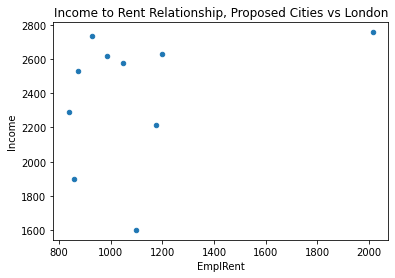

In [109]:
ldn_cluster_df.plot(x='EmplRent',y='Income',kind='scatter', title='Income to Rent Relationship, Proposed Cities vs London')

The next steps here, from the client's perspective, should be to understand how they wish to proceed with the information you have. Now that you have a list of candidate cities, do you want to make a decision based on what's in front of you or do you want to load the model with more data, now that it's built?<br>

For instance, the client could now consider running an employee survey on these 9 cities and feeding the number and tone of responses for each back into the model. It could also ask us to go get the missing commercial rental information we deemed "not too important to go without" at the start, or actively look at the market and find out that information on its own for any specific office spaces it has an eye on, which could then also be plugged in. <br>

There's also value to tweaking the data that already exists, if that's desirable - all of the variables were normalised but if the client wishes to change the weighting on features like distance to the current office, language cross-over, rent to income ratio etc. then they can instruct us to do so.

### Conclusion

The model successfully clustered London with its traditional competitors in the finance space (those being Paris, Milan and Frankfurt), which was very good to see as the client is likely to favour setting up shop in a traditional financial power city if that's the kind of place they were previously located in.<br>

In terms of what can be thought of as a surprise, it was interesting to see that, despite the obvious lingustic, historical and cultural overlap, the model did not see Dublin as a good enough fit, though this tracks well with how Dublin's corporate presence is much more US-influenced than necessarily EU and how narrow the city's corporate scope is, with it being mostly a big pharma and tech hotbed.<br>
